In [1]:
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Attention, Input
from tensorflow.python.ops.init_ops import he_normal
from keras.backend import concatenate
import keras.backend as K

In [2]:
# Define paths
train_dir = 'D:/deep_space/MV/Dataset_split_3/Train'
test_dir = 'D:/deep_space/MV/Dataset_split_3/Test'

In [3]:
# Load and preprocess the training data
input_shape = (256,256, 3)
batch_size=16

# Load and preprocess the test data
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range=[0.64, 1.0],
                                   width_shift_range=0.2,  
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.177)

val_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.177)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    subset='validation'
)


Found 274 images belonging to 4 classes.
Found 57 images belonging to 4 classes.


In [4]:
# Load and preprocess the test data
test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

Found 60 images belonging to 4 classes.


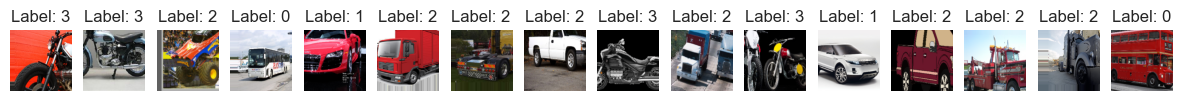

In [5]:
# get img from generator
images, labels = next(train_generator)

# show the img
fig, axes = plt.subplots(1, batch_size, figsize=(15, 5))
for i in range(batch_size):
    axes[i].imshow(images[i])
    axes[i].set_title(f'Label: {np.argmax(labels[i])}')  # show label
    axes[i].axis('off')
plt.show()

In [6]:
def first_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(16, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same',kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    
    att = Attention()([x, x])
    x = x + att
    
    return x


In [7]:
def second_Model(inputs):  # Adjust input shape as per your requirements
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same", kernel_initializer=he_normal())(inputs)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', kernel_initializer=he_normal())(x)
    x = MaxPooling2D((4, 4), strides=(4, 4), padding='same')(x)
    
      
    att = Attention()([x, x])
    x = x + att
    
    return x


In [8]:
def create_combined_model(input_shape=input_shape):
    inputs = Input(shape=input_shape)
    
    branch1 = first_Model(inputs)
    branch2 = second_Model(inputs)
    
    x = concatenate([branch1, branch2], axis=-1)
    
    
    att = Attention()([x, x])
    x = x + att
    x = Conv2D(4096, (1,1), activation='relu')(x)

    x = Dropout(0.3)(x)
    x = GlobalAveragePooling2D()(x)
    output = Dense(4, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage

combined_model = create_combined_model(input_shape)

In [9]:

def custom_categorical_crossentropy(y_true, y_pred):
    epsilon = 1e-10
    y_pred = K.clip(y_pred, epsilon, 1 - epsilon)
    loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1)
    return tf.reduce_mean(loss)

def custom_accuracy(y_true, y_pred):
    # Assuming one-hot encoded vectors
    true_labels = tf.argmax(y_true, axis=-1)
    predicted_labels = tf.argmax(y_pred, axis=-1)

    # Check if the predicted labels match the true labels
    accuracy = tf.reduce_mean(tf.cast(tf.equal(true_labels, predicted_labels), tf.float32))
    
    return accuracy

In [10]:
# Display the model summary
combined_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [11]:
from keras.optimizers import Adam
new_learning_rate = 0.001  # 设置你想要的学习率
custom_optimizer = Adam(lr=new_learning_rate)

# Compile the model
combined_model.compile(optimizer='Adam', 
              loss=custom_categorical_crossentropy, 
              metrics=[custom_accuracy]
              )

C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
# Train the model
history_my_model = combined_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 28s 1s/step - loss: 5.5131 - custom_accuracy: 0.2917 - val_loss: 1.4459 - val_custom_accuracy: 0.2899
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 1.3941 - custom_accuracy: 0.2882 - val_loss: 1.3511 - val_custom_accuracy: 0.3490
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 1.3660 - custom_accuracy: 0.3125 - val_loss: 1.3503 - val_custom_accuracy: 0.3576
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 1.3392 - custom_accuracy: 0.3403 - val_loss: 1.3321 - val_custom_accuracy: 0.3142
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 1.3739 - custom_accuracy: 0.2986 - val_loss: 1.3277 - val_custom_accuracy: 0.2622
Epoch 6/100
18/18 [==============================] - 21s 1s/step - loss: 1.3537 - custom_accuracy: 0.3576 - val_loss: 1.4881 - val_custom_accuracy: 0.2865
Epoch 7/100
18/18 [==============================] - 20s 1s/step - los

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = combined_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 884ms/step - loss: 0.1750 - custom_accuracy: 0.9514
Test Accuracy: 0.9513888955116272
Test loss: 0.1749545931816101


In [14]:
from keras.applications import VGG16

base_model1 = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

In [15]:
from keras.layers import Flatten

# Add custom top layers for classification
x = Flatten()(base_model1.output)
x = Dense(64, activation='relu')(x)
output = Dense(4, activation='softmax')(x)

In [16]:
vgg_model = Model(inputs=base_model1.input, outputs=output)

In [17]:
# Freeze base layers to prevent their weights from being updated
for layer in base_model1.layers:
    layer.trainable = False

In [18]:
# Display the model summary
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0   

In [19]:
# Compile the model
vgg_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
history_vgg = vgg_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 22s 1s/step - loss: 1.4811 - accuracy: 0.5292 - val_loss: 0.3453 - val_accuracy: 0.8947
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 0.5575 - accuracy: 0.7591 - val_loss: 0.3544 - val_accuracy: 0.8772
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 0.3871 - accuracy: 0.8431 - val_loss: 0.2560 - val_accuracy: 0.9123
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 0.3463 - accuracy: 0.8613 - val_loss: 0.2875 - val_accuracy: 0.8947
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 0.3254 - accuracy: 0.9015 - val_loss: 0.3518 - val_accuracy: 0.8947
Epoch 6/100
18/18 [==============================] - 20s 1s/step - loss: 0.2705 - accuracy: 0.9015 - val_loss: 0.3035 - val_accuracy: 0.9123
Epoch 7/100
18/18 [==============================] - 20s 1s/step - loss: 0.2461 - accuracy: 0.9015 - val_loss: 0.4717 - val_accuracy: 0.8596
Epoch 8/100
1

In [21]:
# Evaluate the model on the test set
test_loss, test_accuracy = vgg_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 917ms/step - loss: 0.0344 - accuracy: 0.9818
Test Accuracy: 0.9817517995834351
Test loss: 0.03440060093998909


In [22]:
from keras.applications import ResNet50

base_model2 = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

In [23]:
from keras.layers import Flatten

# Add custom top layers for classification
x = Flatten()(base_model2.output)
output = Dense(4, activation='softmax')(x)

In [24]:
resNet_model = Model(inputs=base_model2.input, outputs=output)

In [25]:
for layer in base_model2.layers:
    layer.trainable = False

In [26]:
# Display the model summary
resNet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [27]:
# Compile the model
resNet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [28]:
history_resNet = resNet_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 24s 1s/step - loss: 13.8137 - accuracy: 0.2482 - val_loss: 4.3655 - val_accuracy: 0.4386
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 5.6245 - accuracy: 0.3723 - val_loss: 6.7561 - val_accuracy: 0.4561
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 3.9380 - accuracy: 0.4343 - val_loss: 3.4811 - val_accuracy: 0.5088
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 3.2504 - accuracy: 0.4015 - val_loss: 4.5862 - val_accuracy: 0.3684
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 2.0904 - accuracy: 0.4964 - val_loss: 1.5735 - val_accuracy: 0.5789
Epoch 6/100
18/18 [==============================] - 20s 1s/step - loss: 2.5411 - accuracy: 0.5036 - val_loss: 7.4451 - val_accuracy: 0.3860
Epoch 7/100
18/18 [==============================] - 20s 1s/step - loss: 2.4746 - accuracy: 0.4781 - val_loss: 2.1692 - val_accuracy: 0.5965
Epoch 8/100


In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = resNet_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 929ms/step - loss: 1.2466 - accuracy: 0.7299
Test Accuracy: 0.7299270033836365
Test loss: 1.2465590238571167


In [30]:
from keras.applications.efficientnet import EfficientNet, EfficientNetB0

base_model3 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=input_shape)

In [31]:
from keras.layers import Flatten

# Add custom top layers for classification
x = Flatten()(base_model3.output)
output = Dense(4, activation='softmax')(x)

In [32]:
effNet_model = Model(inputs=base_model3.input, outputs=output)

In [33]:
for layer in base_model3.layers:
    layer.trainable = False

In [34]:
# Display the model summary
effNet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_4[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0]']    

In [35]:
# Compile the model
effNet_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [36]:
history_effNet = effNet_model.fit(train_generator, validation_data=(val_generator), epochs=100)

Epoch 1/100
18/18 [==============================] - 26s 1s/step - loss: 9.9382 - accuracy: 0.2190 - val_loss: 3.9003 - val_accuracy: 0.2456
Epoch 2/100
18/18 [==============================] - 20s 1s/step - loss: 3.9107 - accuracy: 0.2774 - val_loss: 2.8735 - val_accuracy: 0.2632
Epoch 3/100
18/18 [==============================] - 20s 1s/step - loss: 3.1873 - accuracy: 0.2664 - val_loss: 2.0030 - val_accuracy: 0.2456
Epoch 4/100
18/18 [==============================] - 20s 1s/step - loss: 2.3661 - accuracy: 0.2555 - val_loss: 3.8224 - val_accuracy: 0.2632
Epoch 5/100
18/18 [==============================] - 20s 1s/step - loss: 3.1383 - accuracy: 0.2737 - val_loss: 3.6892 - val_accuracy: 0.2456
Epoch 6/100
18/18 [==============================] - 20s 1s/step - loss: 3.1740 - accuracy: 0.2263 - val_loss: 2.7543 - val_accuracy: 0.2456
Epoch 7/100
18/18 [==============================] - 20s 1s/step - loss: 2.9739 - accuracy: 0.2920 - val_loss: 5.8521 - val_accuracy: 0.2456
Epoch 8/100
1

In [37]:
# Evaluate the model on the test set
test_loss, test_accuracy = effNet_model.evaluate(train_generator)
print('Test Accuracy:',test_accuracy)
print('Test loss:',test_loss )

18/18 [==============================] - 17s 951ms/step - loss: 4.5943 - accuracy: 0.2482
Test Accuracy: 0.24817518889904022
Test loss: 4.594262599945068


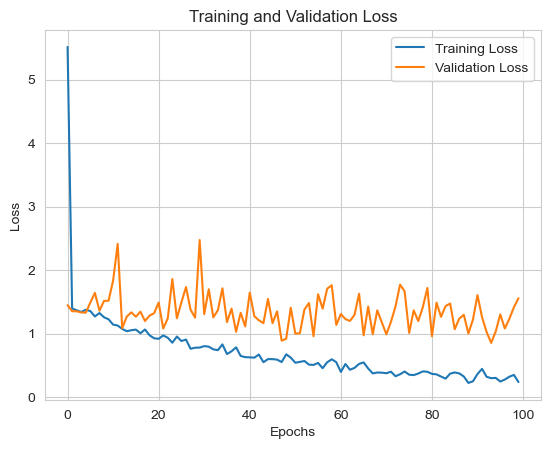

In [38]:
plt.plot(history_my_model.history['loss'], label='Training Loss')
plt.plot(history_my_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

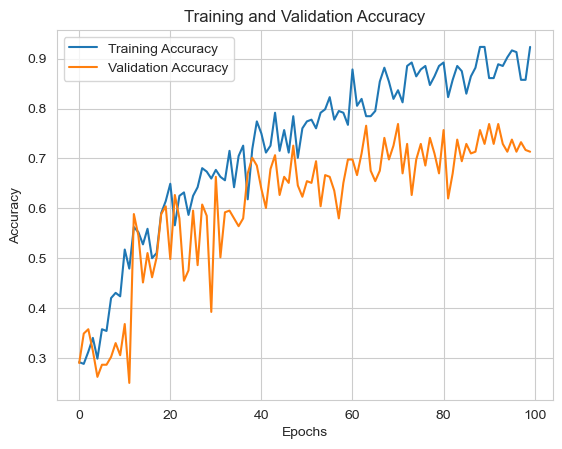

In [39]:
plt.plot(history_my_model.history['custom_accuracy'], label='Training Accuracy')
plt.plot(history_my_model.history['val_custom_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve

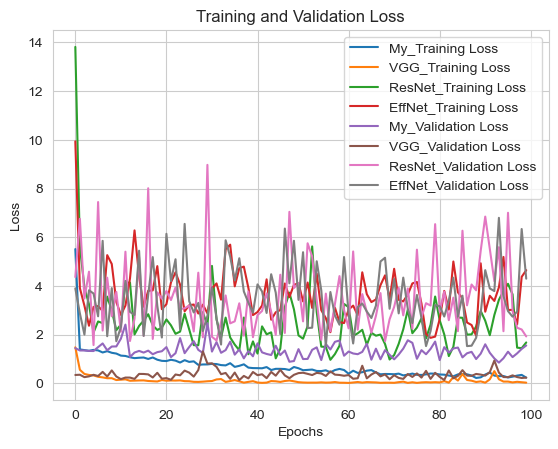

In [41]:
# Plot Training and Validation Loss
plt.plot(history_my_model.history['loss'], label='My_Training Loss')
plt.plot(history_vgg.history['loss'], label='VGG_Training Loss')
plt.plot(history_resNet.history['loss'], label='ResNet_Training Loss')
plt.plot(history_effNet.history['loss'], label='EffNet_Training Loss')
plt.plot(history_my_model.history['val_loss'], label='My_Validation Loss')
plt.plot(history_vgg.history['val_loss'], label='VGG_Validation Loss')
plt.plot(history_resNet.history['val_loss'], label='ResNet_Validation Loss')
plt.plot(history_effNet.history['val_loss'], label='EffNet_Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

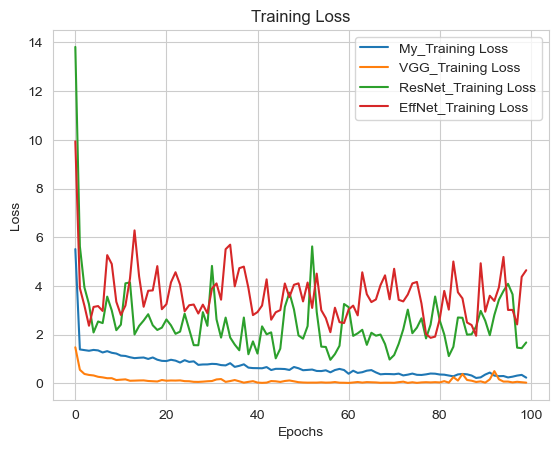

In [42]:
plt.plot(history_my_model.history['loss'], label='My_Training Loss')
plt.plot(history_vgg.history['loss'], label='VGG_Training Loss')
plt.plot(history_resNet.history['loss'], label='ResNet_Training Loss')
plt.plot(history_effNet.history['loss'], label='EffNet_Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

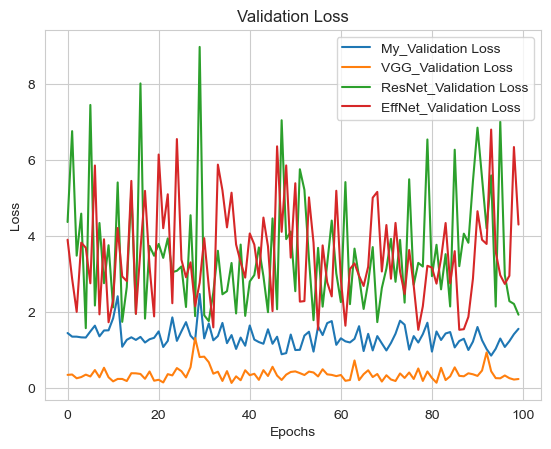

In [43]:
plt.plot(history_my_model.history['val_loss'], label='My_Validation Loss')
plt.plot(history_vgg.history['val_loss'], label='VGG_Validation Loss')
plt.plot(history_resNet.history['val_loss'], label='ResNet_Validation Loss')
plt.plot(history_effNet.history['val_loss'], label='EffNet_Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

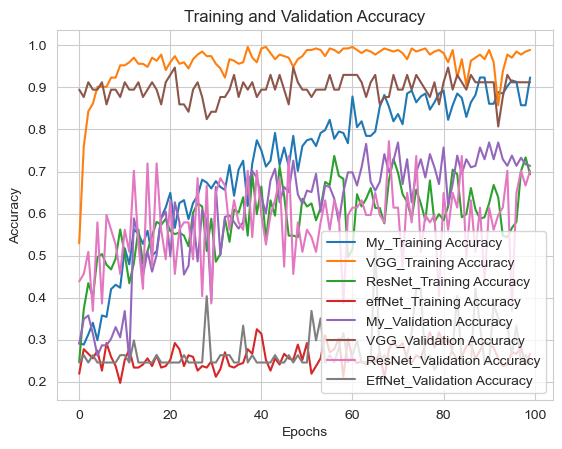

In [44]:
# Plot Training and Validation Accuracy
plt.plot(history_my_model.history['custom_accuracy'], label='My_Training Accuracy')
plt.plot(history_vgg.history['accuracy'], label='VGG_Training Accuracy')
plt.plot(history_resNet.history['accuracy'], label='ResNet_Training Accuracy')
plt.plot(history_effNet.history['accuracy'], label='effNet_Training Accuracy')
plt.plot(history_my_model.history['val_custom_accuracy'], label='My_Validation Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='VGG_Validation Accuracy')
plt.plot(history_resNet.history['val_accuracy'], label='ResNet_Validation Accuracy')
plt.plot(history_effNet.history['val_accuracy'], label='EffNet_Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

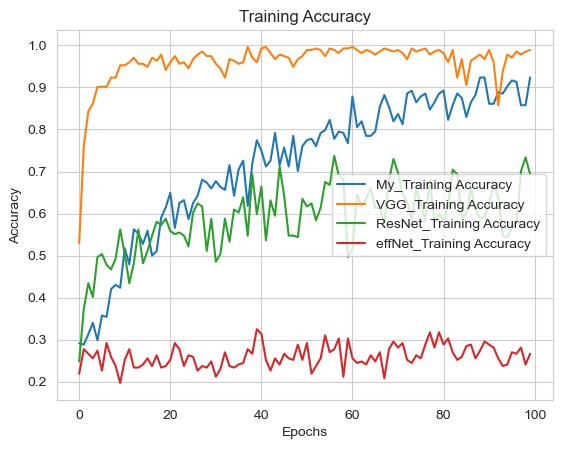

In [45]:
plt.plot(history_my_model.history['custom_accuracy'], label='My_Training Accuracy')
plt.plot(history_vgg.history['accuracy'], label='VGG_Training Accuracy')
plt.plot(history_resNet.history['accuracy'], label='ResNet_Training Accuracy')
plt.plot(history_effNet.history['accuracy'], label='effNet_Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

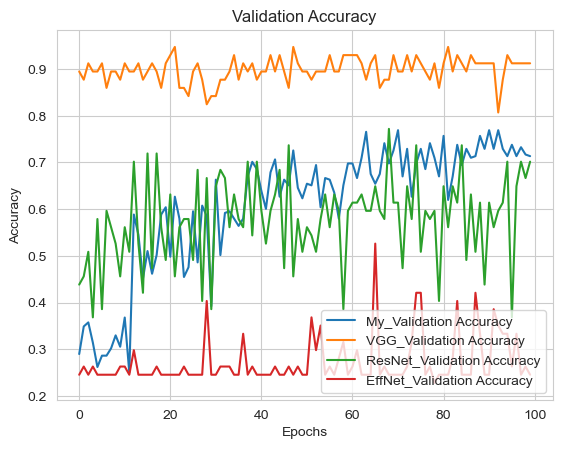

In [46]:
plt.plot(history_my_model.history['val_custom_accuracy'], label='My_Validation Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='VGG_Validation Accuracy')
plt.plot(history_resNet.history['val_accuracy'], label='ResNet_Validation Accuracy')
plt.plot(history_effNet.history['val_accuracy'], label='EffNet_Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [47]:
# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_prob, num_classes):
    plt.figure(figsize=(8, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()

4/4 [==============================] - 5s 1s/step


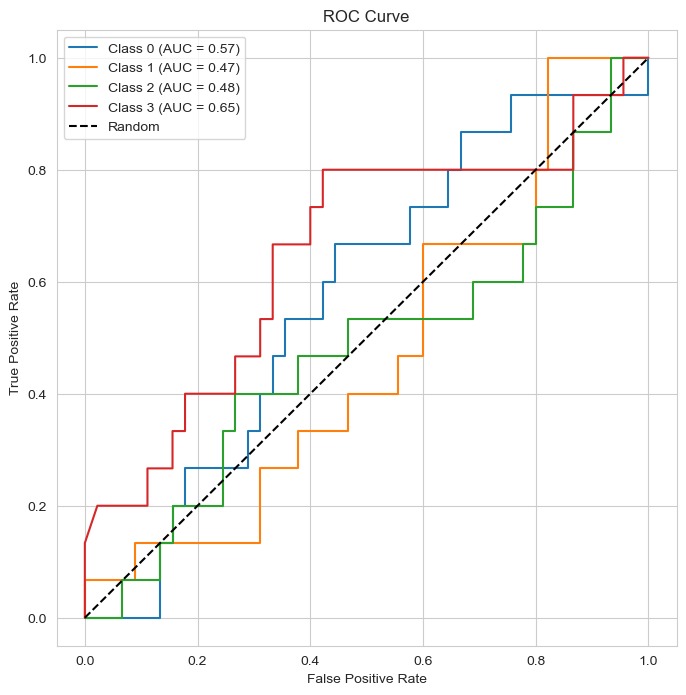

In [48]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
my_y_pred_prob = combined_model.predict(test_generator)

# Convert class labels to binary indicator matrix
my_y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(my_y_true_binary, my_y_pred_prob, num_classes=4)

In [49]:
# Evaluate the model on the test set
test_generator.reset()
my_y_prob = combined_model.predict(test_generator)
my_y_true = test_generator.classes
my_y_pred = np.argmax(my_y_prob, axis=1)

4/4 [==============================] - 4s 1s/step


Report:
              precision    recall  f1-score   support

           0       0.12      0.13      0.12        15
           1       0.25      0.20      0.22        15
           2       0.62      0.33      0.43        15
           3       0.22      0.33      0.26        15

    accuracy                           0.25        60
   macro avg       0.30      0.25      0.26        60
weighted avg       0.30      0.25      0.26        60


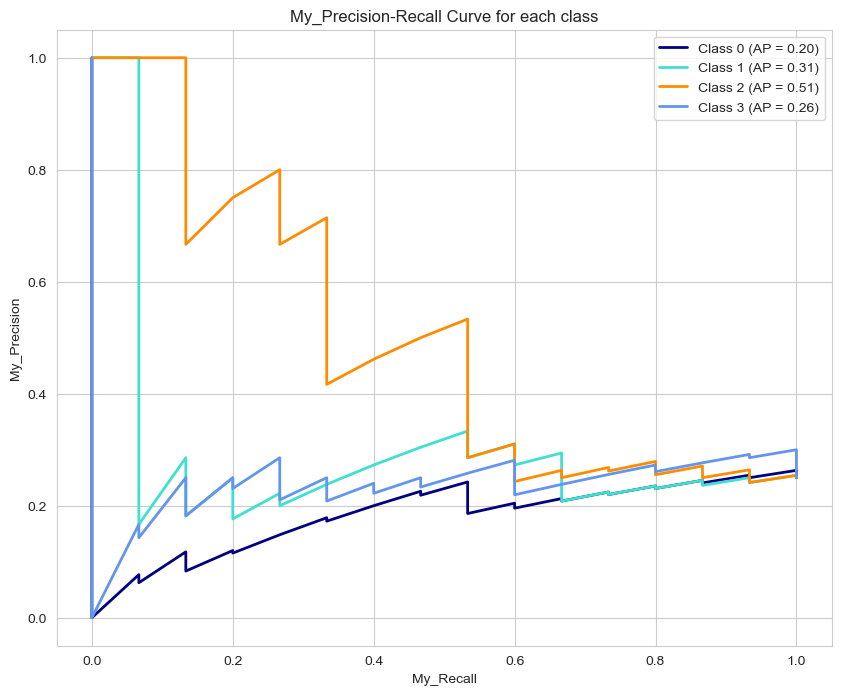

In [50]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Report:")
print(classification_report(my_y_true, my_y_pred))

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(my_y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], my_y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], my_y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('My_Recall')
plt.ylabel('My_Precision')
plt.title('My_Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(my_y_true, my_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Extract true negatives, false positives, false negatives, and true positives based on the shape
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Print classification report
print("my Classification Report:")
print(classification_report(my_y_true, my_y_pred))


NameError: name 'my_y_true' is not defined

4/4 [==============================] - 5s 1s/step


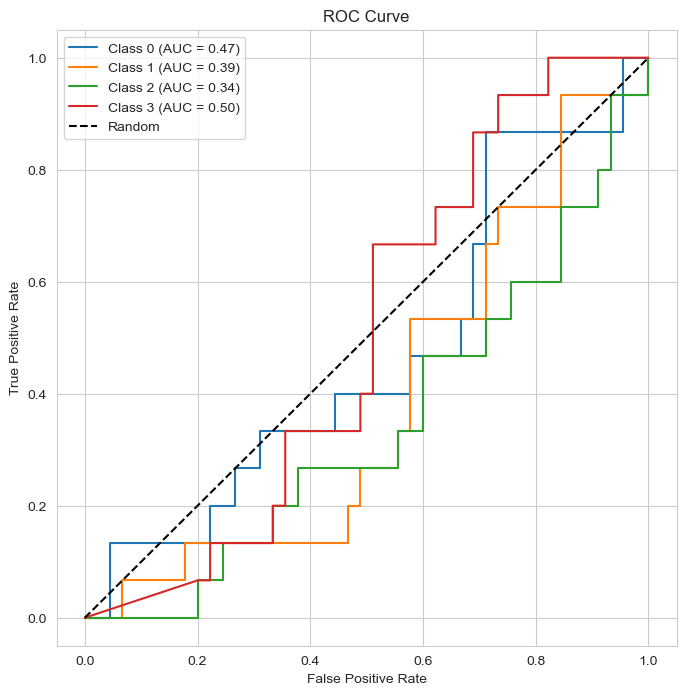

In [52]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
y_pred_prob = vgg_model.predict(test_generator)

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(y_true_binary, y_pred_prob, num_classes=4)

In [53]:
# Evaluate the model on the test set
test_generator.reset()
vgg_y_prob = vgg_model.predict(test_generator)
vgg_y_true = test_generator.classes
vgg_y_pred = np.argmax(vgg_y_prob, axis=1)

4/4 [==============================] - 4s 1s/step


Report:
              precision    recall  f1-score   support

           0       0.30      0.40      0.34        15
           1       0.33      0.33      0.33        15
           2       0.40      0.27      0.32        15
           3       0.33      0.33      0.33        15

    accuracy                           0.33        60
   macro avg       0.34      0.33      0.33        60
weighted avg       0.34      0.33      0.33        60


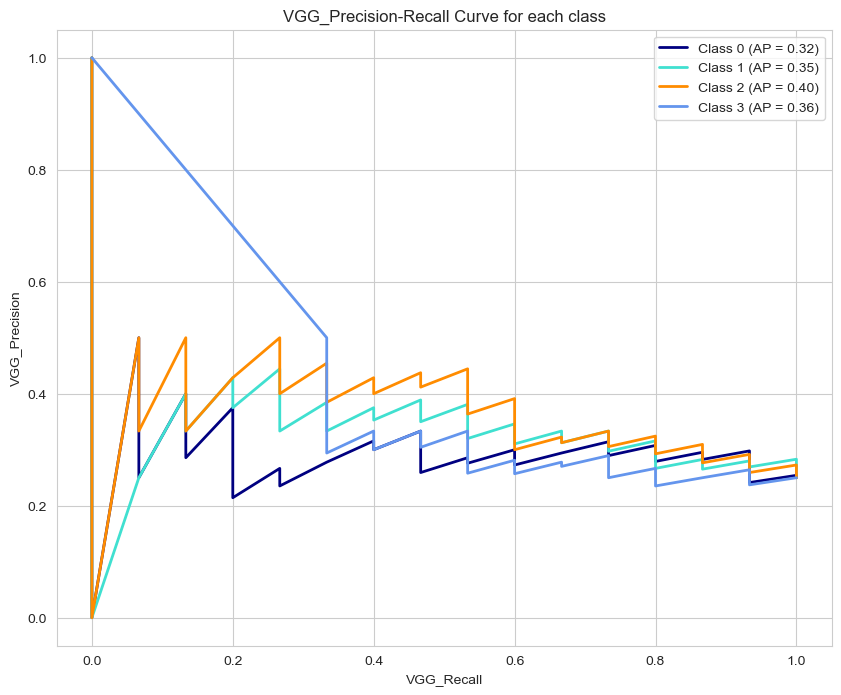

In [54]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Report:")
print(classification_report(vgg_y_true, vgg_y_pred))

# Convert class labels to binary indicator matrix
vgg_y_true_binary = to_categorical(vgg_y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(vgg_y_true_binary[:, i], vgg_y_prob[:, i])
    average_precision[i] = average_precision_score(vgg_y_true_binary[:, i], vgg_y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('VGG_Recall')
plt.ylabel('VGG_Precision')
plt.title('VGG_Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(vgg_y_true, vgg_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Extract true negatives, false positives, false negatives, and true positives based on the shape
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Print classification report
print("vgg Classification Report:")
print(classification_report(vgg_y_true, vgg_y_pred))


NameError: name 'vgg_y_true' is not defined

4/4 [==============================] - 6s 1s/step


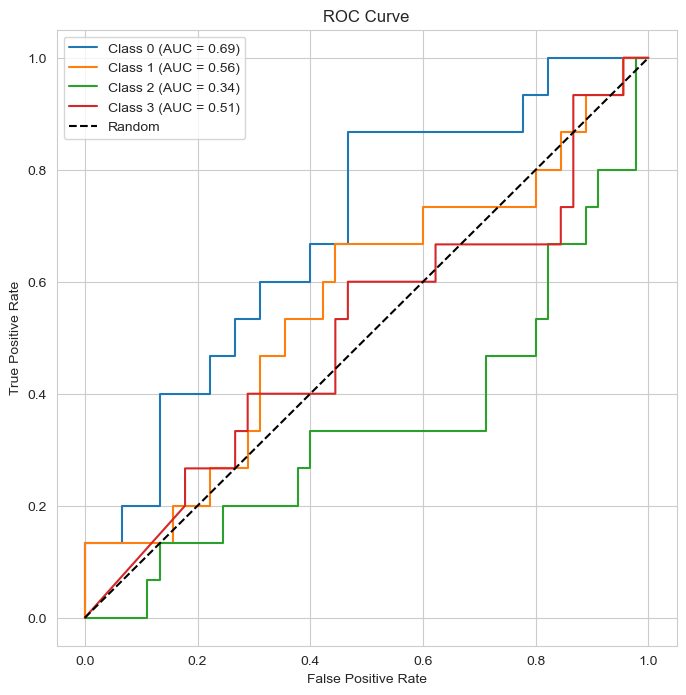

In [56]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
resNet_y_pred_prob = resNet_model.predict(test_generator)

# Convert class labels to binary indicator matrix
resNet_y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(resNet_y_true_binary, resNet_y_pred_prob, num_classes=4)

In [57]:
# Evaluate the model on the test set
test_generator.reset()
resNet_y_prob = resNet_model.predict(test_generator)
resNet_y_true = test_generator.classes
resNet_y_pred = np.argmax(resNet_y_prob, axis=1)

4/4 [==============================] - 5s 1s/step


Report:
              precision    recall  f1-score   support

           0       0.25      0.07      0.11        15
           1       0.28      0.33      0.30        15
           2       0.29      0.40      0.33        15
           3       0.29      0.33      0.31        15

    accuracy                           0.28        60
   macro avg       0.28      0.28      0.26        60
weighted avg       0.28      0.28      0.26        60


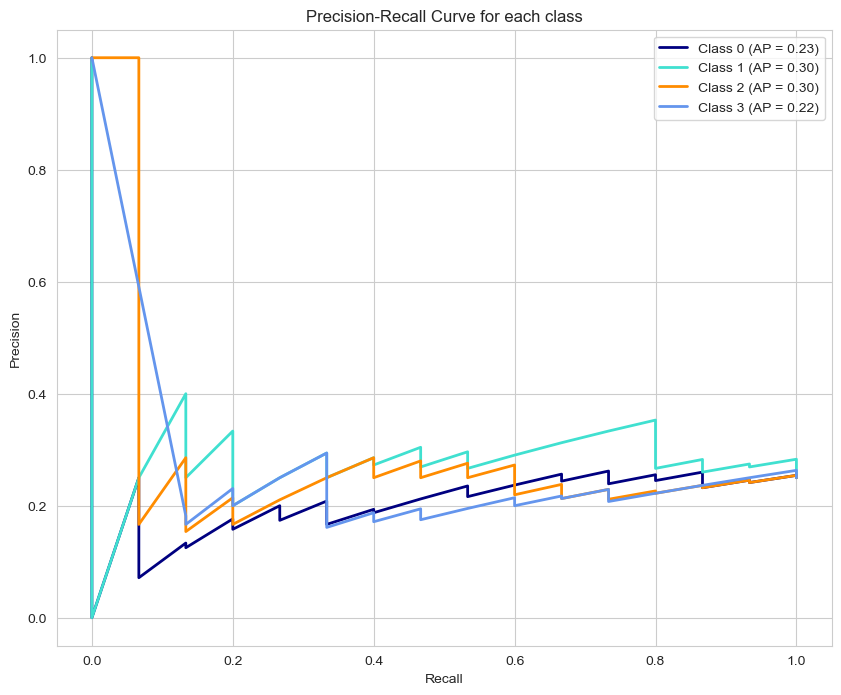

In [58]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Report:")
print(classification_report(resNet_y_true, resNet_y_pred))

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(resNet_y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], resNet_y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], resNet_y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(resNet_y_true, resNet_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Extract true negatives, false positives, false negatives, and true positives based on the shape
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(resNet_y_true, resNet_y_pred))


NameError: name 'resNet_y_true' is not defined

4/4 [==============================] - 7s 2s/step


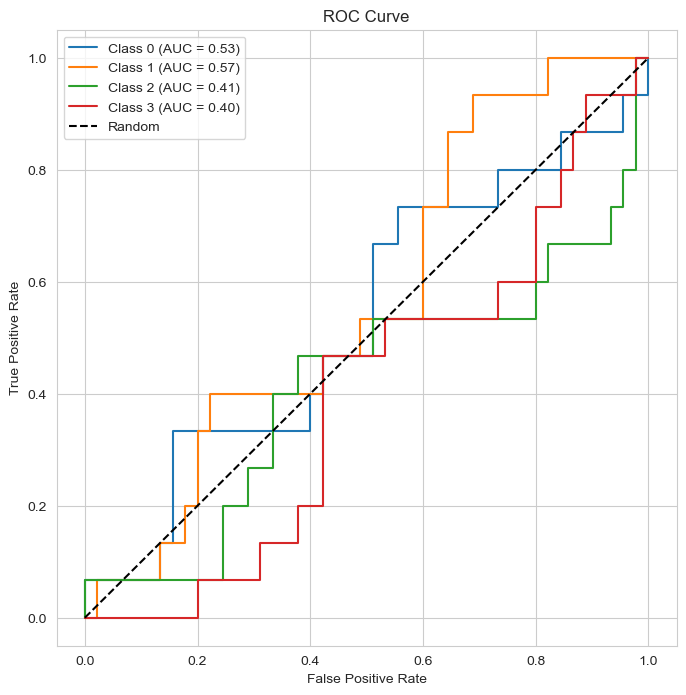

In [60]:
from keras.utils import to_categorical
# Convert class labels to binary indicator matrix
effNet_y_pred_prob = effNet_model.predict(test_generator)

# Convert class labels to binary indicator matrix
effNet_y_true_binary = to_categorical(test_generator.classes, num_classes=4)

# Plot ROC Curve
plot_roc_curve(effNet_y_true_binary, effNet_y_pred_prob, num_classes=4)

In [61]:
# Evaluate the model on the test set
test_generator.reset()
effNet_y_prob = effNet_model.predict(test_generator)
effNet_y_true = test_generator.classes
effNet_y_pred = np.argmax(effNet_y_prob, axis=1)

4/4 [==============================] - 5s 1s/step


Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        15
           2       0.25      1.00      0.40        15
           3       0.00      0.00      0.00        15

    accuracy                           0.25        60
   macro avg       0.06      0.25      0.10        60
weighted avg       0.06      0.25      0.10        60


C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Fischer\.conda\envs\dtw\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


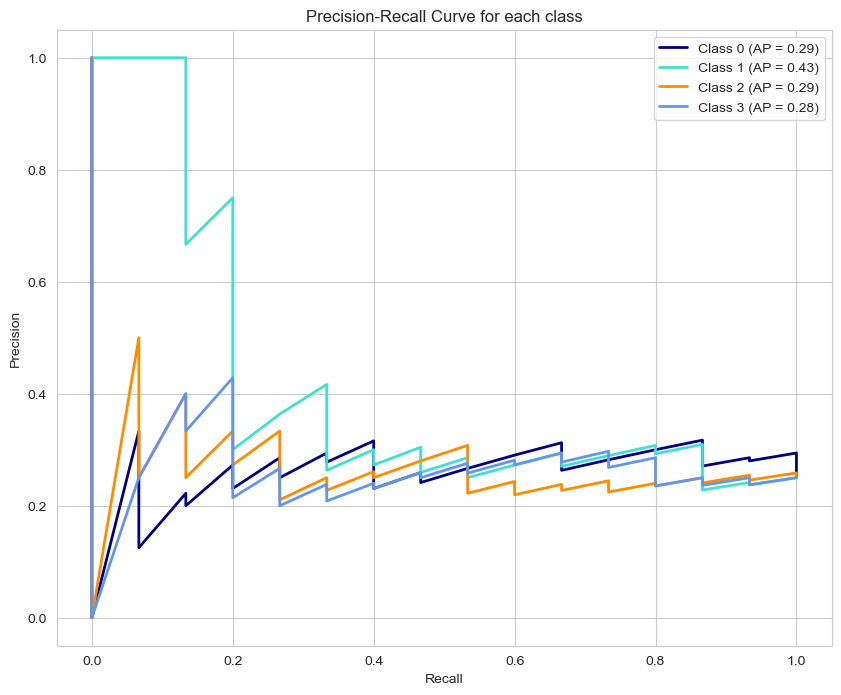

In [62]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Classification Report
print("Report:")
print(classification_report(effNet_y_true, effNet_y_pred))

# Convert class labels to binary indicator matrix
y_true_binary = to_categorical(effNet_y_true, num_classes=4)

# Precision-Recall Curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(4):  # Assuming 4 classes
    precision[i], recall[i], _ = precision_recall_curve(y_true_binary[:, i], effNet_y_prob[:, i])
    average_precision[i] = average_precision_score(y_true_binary[:, i], effNet_y_prob[:, i])

# Plot Precision-Recall Curve for each class
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue'])
plt.figure(figsize=(10, 8))

for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend()
plt.show()

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Calculate confusion matrix
cm = confusion_matrix(effNet_y_true, effNet_y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Extract true negatives, false positives, false negatives, and true positives based on the shape
tn, fp, fn, tp = cm.ravel()

# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print sensitivity and specificity
print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(effNet_y_true, effNet_y_pred))


NameError: name 'effNet_y_true' is not defined

In [ ]:
# combined_model.save("model90.h5")